# 基于多因子数据股价预测的PatchTST 

## 1、引入依赖库

In [1]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [42]:
import sklearn
from tsai.basics import *
import pandas as pd

## 2、数据准备

在训练之前，需要将数据转换为模型要求的指定的格式：

1. 将数据读取成pandas的DataFrame结构，其中包含要预测的变量
2. 对数据进行预处理（缺失值、极值、标准化）
3. 定义训练集、测试集和验证集的划分
4. 使用train split函数对数据进行拆分
5. 应用滑动窗口来准备输入和输出的数据

### 2.1 准备DataFrame数据

在本研究中，我们使用沪深300指数中股票的多因子历史数据，整理来说，此任务是一个多变量长期时序预测问题（Long-term time series forecasting, LTSF）, 利用多个历史时间步长的多变量数据预测多个未来时间步长的单变量数据。

In [43]:
dataset = pd.read_csv('data/selected_data.csv')

In [44]:
dataset.head()

,date,asset,asset_impairment_loss_ttm,cash_flow_to_price_ratio,operating_revenue_per_share,cumulative_range,daily_standard_deviation,debt_to_assets,TRIX5,TRIX10,...,Variance60,equity_to_fixed_asset_ratio,average_share_turnover_annual,debt_to_tangible_equity_ratio,debt_to_equity_ratio,debt_to_asset_ratio,average_share_turnover_quarterly,beta,account_receivable_turnover_rate,price
0,2010-01-04,000001.XSHE,1.082840,-1.782851,0.138523,-0.015082,-0.130014,0.949743,-0.669114,-0.467289,...,-0.059143,0.389722,-0.627465,0.873913,0.907126,0.948828,-0.743923,-0.474340,-1.569855e-13,-0.175372
1,2010-01-04,000002.XSHE,1.872958,0.550676,0.009427,-0.512981,-0.524570,0.313397,0.012472,0.198167,...,-0.542034,0.462059,-0.318455,0.058255,0.305223,0.311860,-0.109738,-0.282214,-2.677858e-13,-0.746300
2,2010-01-04,000009.XSHE,-0.408687,0.564045,-0.124014,-0.486472,-0.092968,0.057058,-0.044310,-0.172772,...,-0.166335,-1.426181,0.304952,-0.175558,0.215119,0.030641,0.178116,-0.207993,-3.752554e-14,-0.764651
3,2010-01-04,000012.XSHE,1.574693,-0.597120,-1.334493,-0.020186,0.684936,-0.775392,0.037010,-0.086281,...,0.312496,-0.702248,0.382009,-1.308295,-1.195322,-0.799087,0.290596,1.094184,-5.084821e-14,0.021916
4,2010-01-04,000021.XSHE,-0.212554,0.028205,0.873796,0.739504,0.271701,-0.815003,-0.463916,-1.281419,...,-0.024420,-0.353840,-0.065789,-0.425548,-0.451862,-0.829157,-0.581038,0.157243,-2.708944e-14,-0.036210


### 2.2 数据预处理

对数据进行预处理，在输入模型前对因子数据再一次进行缺失值、重复值处理。tsai库提供了一些sklearn风格的转换函数，用于构建预处理管道。在本研究中，我们使用以下转换函数：

1. TSShrinkDataFrame: to save some memory and set the right dtypes.
2. TSDropDuplicates: to ensure there are no duplicate timestamps.
3. TSAddMissingTimestamps: to fill any missing timestamps.
4. TSFillMissing: to fill any missing data (forward fill, then 0).

小Tips：按照股票代码对原始数据分组，取出每个股票代码的历史因子数据，分别对每个数据进行

In [45]:
datetime_col = "date"
freq = '1D'
columns = dataset.columns[2:]
method = 'ffill'
value = 0

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ], 
    verbose=True)
mkdir('data', exist_ok=True, parents=True)
save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

dataset = preproc_pipe.fit_transform(dataset)
# dataset = dataset.sort_values(by=['date', 'asset'])
dataset.head()

data directory already exists.
Pipeline saved as data/preproc_pipe.pkl
Initial memory usage: 365.67 MB 
Final memory usage  : 179.48 MB  (-50.9%)
[Pipeline] .......... (step 1 of 2) Processing shrinker, total=   0.6s
[Pipeline] ...... (step 2 of 2) Processing fill_missing, total=   2.8s


,date,asset,asset_impairment_loss_ttm,cash_flow_to_price_ratio,operating_revenue_per_share,cumulative_range,daily_standard_deviation,debt_to_assets,TRIX5,TRIX10,...,Variance60,equity_to_fixed_asset_ratio,average_share_turnover_annual,debt_to_tangible_equity_ratio,debt_to_equity_ratio,debt_to_asset_ratio,average_share_turnover_quarterly,beta,account_receivable_turnover_rate,price
0,2010-01-04,000001.XSHE,1.082840,-1.782851,0.138523,-0.015082,-0.130014,0.949743,-0.669114,-0.467289,...,-0.059143,0.389722,-0.627465,0.873913,0.907126,0.948828,-0.743923,-0.474340,-1.569855e-13,-0.175372
1,2010-01-04,000002.XSHE,1.872958,0.550676,0.009427,-0.512981,-0.524570,0.313397,0.012472,0.198167,...,-0.542034,0.462059,-0.318455,0.058255,0.305223,0.311860,-0.109738,-0.282214,-2.677858e-13,-0.746300
2,2010-01-04,000009.XSHE,-0.408687,0.564045,-0.124014,-0.486472,-0.092968,0.057058,-0.044310,-0.172772,...,-0.166335,-1.426181,0.304952,-0.175558,0.215119,0.030641,0.178116,-0.207993,-3.752554e-14,-0.764651
3,2010-01-04,000012.XSHE,1.574693,-0.597120,-1.334493,-0.020186,0.684936,-0.775392,0.037010,-0.086281,...,0.312496,-0.702248,0.382009,-1.308295,-1.195322,-0.799087,0.290596,1.094184,-5.084821e-14,0.021916
4,2010-01-04,000021.XSHE,-0.212554,0.028205,0.873796,0.739504,0.271701,-0.815003,-0.463915,-1.281419,...,-0.024420,-0.353840,-0.065789,-0.425548,-0.451862,-0.829157,-0.581038,0.157243,-2.708944e-14,-0.036210


### 2.3 定义数据拆分

将具有 个时间步长和  个特征（不包括日期时间）的多元时间序列转换为：

- 个输入样本，包含 个因子特征值和 历史时间步长
- 个输入样本，包含 个因子特征值和 未来时间步长

我们使用tsai库中的get_forecasting_splits函数实现

In [46]:
dataset.reset_index(inplace=True)
dataset.set_index(['date', 'asset'], inplace=True)
dataset.drop(columns=['index'], inplace=True)
factor_names = dataset.columns.tolist()
stock_codes = dataset.index.levels[1].tolist()
trade_dates = dataset.index.levels[0].tolist()

In [47]:
len(factor_names), len(stock_codes), len(trade_dates)

(51, 372, 2431)

In [48]:
dataset.head()

asset_impairment_loss_ttm  cash_flow_to_price_ratio  \
date       asset                                                              
2010-01-04 000001.XSHE                   1.082840                 -1.782851   
           000002.XSHE                   1.872958                  0.550676   
           000009.XSHE                  -0.408687                  0.564045   
           000012.XSHE                   1.574693                 -0.597120   
           000021.XSHE                  -0.212554                  0.028205   

                        operating_revenue_per_share  cumulative_range  \
date       asset                                                        
2010-01-04 000001.XSHE                     0.138523         -0.015082   
           000002.XSHE                     0.009427         -0.512981   
           000009.XSHE                    -0.124014         -0.486472   
           000012.XSHE                    -1.334493         -0.020186   
           000021.XSHE                     0.873796          0.739504   

                        daily_standard_deviation  debt_to_assets     TRIX5  \
date       asset                                                             
2010-01-04 000001.XSHE                 -0.130014        0.949743 -0.669114   
           000002.XSHE                 -0.524570        0.313397  0.012472   
           000009.XSHE                 -0.092968        0.057058 -0.044310   
           000012.XSHE                  0.684936       -0.775392  0.037010   
           000021.XSHE                  0.271701       -0.815003 -0.463915   

                          TRIX10  single_day_VPT_6  single_day_VPT_12  ...  \
date       asset                                                       ...   
2010-01-04 000001.XSHE -0.467289          0.629844          -1.044537  ...   
           000002.XSHE  0.198167          1.460589          -1.034271  ...   
           000009.XSHE -0.172772          0.194103           0.466682  ...   
           000012.XSHE -0.086281          0.160596          -0.628887  ...   
           000021.XSHE -1.281419          0.179706          -0.441030  ...   

                        Variance60  equity_to_fixed_asset_ratio  \
date       asset                                                  
2010-01-04 000001.XSHE   -0.059143                     0.389722   
           000002.XSHE   -0.542034                     0.462059   
           000009.XSHE   -0.166335                    -1.426181   
           000012.XSHE    0.312496                    -0.702248   
           000021.XSHE   -0.024420                    -0.353840   

                        average_share_turnover_annual  \
date       asset                                        
2010-01-04 000001.XSHE                      -0.627465   
           000002.XSHE                      -0.318455   
           000009.XSHE                       0.304952   
           000012.XSHE                       0.382009   
           000021.XSHE                      -0.065789   

                        debt_to_tangible_equity_ratio  debt_to_equity_ratio  \
date       asset                                                              
2010-01-04 000001.XSHE                       0.873913              0.907126   
           000002.XSHE                       0.058255              0.305223   
           000009.XSHE                      -0.175558              0.215119   
           000012.XSHE                      -1.308295             -1.195322   
           000021.XSHE                      -0.425548             -0.451862   

                        debt_to_asset_ratio  average_share_turnover_quarterly  \
date       asset                                                                
2010-01-04 000001.XSHE             0.948828                         -0.743923   
           000002.XSHE             0.311860                         -0.109738   
           000009.XSHE             0.030641                          0.178116   
           000012.XSHE            -

### 2.4 根据滑动窗口的大小准备模型输入数据

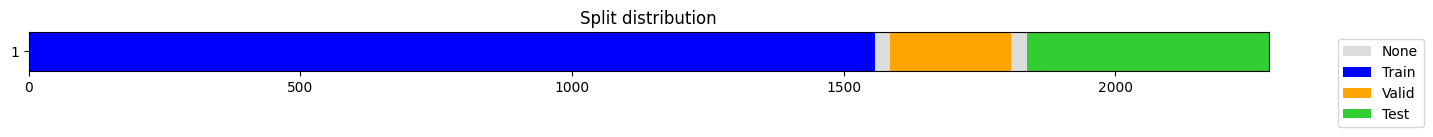

In [49]:
fcst_history = 120 # steps for the past
fcst_horizon = 30  # steps for the future

valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

stock = stock_codes[0]
df_show = dataset.loc[(slice(None), stock), :]
df_show.reset_index(inplace=True)

split = get_forecasting_splits(df_show, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
train_split, valid_split, test_split = split
add_len= len(train_split)+len(valid_split)+len(test_split)


In [50]:
columns = df_show.columns[2:]
# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

data directory already exists.
Pipeline saved as data/exp_pipe.pkl


In [66]:
from fastcore.foundation import L
import numpy as np

splits = tuple()

train_splits = []
valid_splits = []
test_splits = []

X_data = None
y_data = None
trade_dates = dataset.index.levels[0].tolist()
len_dates = len(trade_dates)

count = 0
for stock in stock_codes:
    print(str(count) + 'th stock: ', stock)
    stock_df = dataset.loc[(slice(None), stock), :]
    # print('stock_df.shape: ', stock_df.shape)
    # print('stock_df.shape: ', stock_df.shape)
    # print('x_vars: ', x_vars)
    # print('y_vars: ', y_vars)
    # print(stock_df.head())
    stock_df.reset_index(inplace=True)
    stock_df = exp_pipe.fit_transform(stock_df.loc[:], scaler__idxs=train_split)
    for index in train_split:
        train_splits.append(index + count * add_len)
    for index in valid_split:
        valid_splits.append(index + count * add_len)
    for index in test_split:
        test_splits.append(index + count * add_len)
    count += 1
    # print(stock_df.head())
    x_vars = stock_df.columns[2:] # 预测的基准变量
    y_vars = stock_df.columns[-1] # 要预测的变量
    X, y = prepare_forecasting_data(stock_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    X_data = X if X_data is None else np.concatenate((X_data, X), axis=0)
    y_data = y if y_data is None else np.concatenate((y_data, y), axis=0)
    # print('X_data.shape: ', X_data.shape)
    # print('y_data.shape: ', y_data.shape)
    if count == 10:
        break

train_splits = L(train_splits)
valid_splits = L(valid_splits)
test_splits = L(test_splits)

splits += (train_splits,)
splits += (valid_splits,)
splits += (test_splits,)

0th stock:  000001.XSHE
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
1th stock:  000002.XSHE
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
2th stock:  000009.XSHE
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
3th stock:  000012.XSHE
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
4th stock:  000021.XSHE
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
5th stock:  000027.XSHE
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
6th stock:  000031.XSHE
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
7th stock:  000039.XSHE
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
8th stock:  000046.XSHE
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
9th stock:  000060.XSHE
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


In [67]:
splits

((#15570) [0,1,2,3,4,5,6,7,8,9...],
 (#2220) [1586,1587,1588,1589,1590,1591,1592,1593,1594,1595...],
 (#4450) [1837,1838,1839,1840,1841,1842,1843,1844,1845,1846...])

In [68]:
type(X_data[0][0][0]), type(y_data[0][0][0])

(numpy.float32, numpy.float32)

## 3 模型设计

In [69]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=24,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

In [70]:
learn = TSForecaster(X_data, y_data, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

In [71]:
learn.summary()


not enough values to plot a chart


PatchTST (Input shape: 16 x 51 x 120)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 51 x 30        
RevIN                                     102        True      
____________________________________________________________________________
                     16 x 51 x 122       
ReplicationPad1d                                               
____________________________________________________________________________
                     16 x 24 x 50        
Unfold                                                         
____________________________________________________________________________
                     16 x 51 x 50 x 16   
Linear                                    400        True      
Dropout                                                        
Linear                                    272        True      
Linear                                    272        True      
Linear                                    272      

## 4 模型训练

In [72]:
n_epochs = 100
lr_max = 0.001
# lr_max = 0.0025
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')

RuntimeError: The size of tensor a (24480) must match the size of tensor b (480) at non-singleton dimension 0

## 模型评估

In [ ]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(X_data[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y_data[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df

## 模型测试


In [ ]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X_data[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y_data[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

## 可视化

In [ ]:
X_test = X_data[splits[2]]
y_test = y_data[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)

## 模型实际应用